
**Import Libraries**

In [1]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import os
import time
from mpl_toolkits.mplot3d import Axes3D
from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scipy.ndimage.measurements import label
%matplotlib inline



***Load Training data set***

In [2]:

cars = []
notcars = []

# Read in cars 
for folder in os.listdir(path='./vehicles'):
    if folder != '.DS_Store':
        for file in os.listdir(path='./vehicles/'+folder):
            if file != '.DS_Store':
                cars.append("./vehicles/"+folder+"/"+file)
# Read in notcars   
for folder in os.listdir(path='./non-vehicles'):
    if folder != '.DS_Store':
        for file in os.listdir(path='./non-vehicles/'+folder):
            if file != '.DS_Store':
                notcars.append("./non-vehicles/"+folder+"/"+file)

*** Visualize classes in data set***

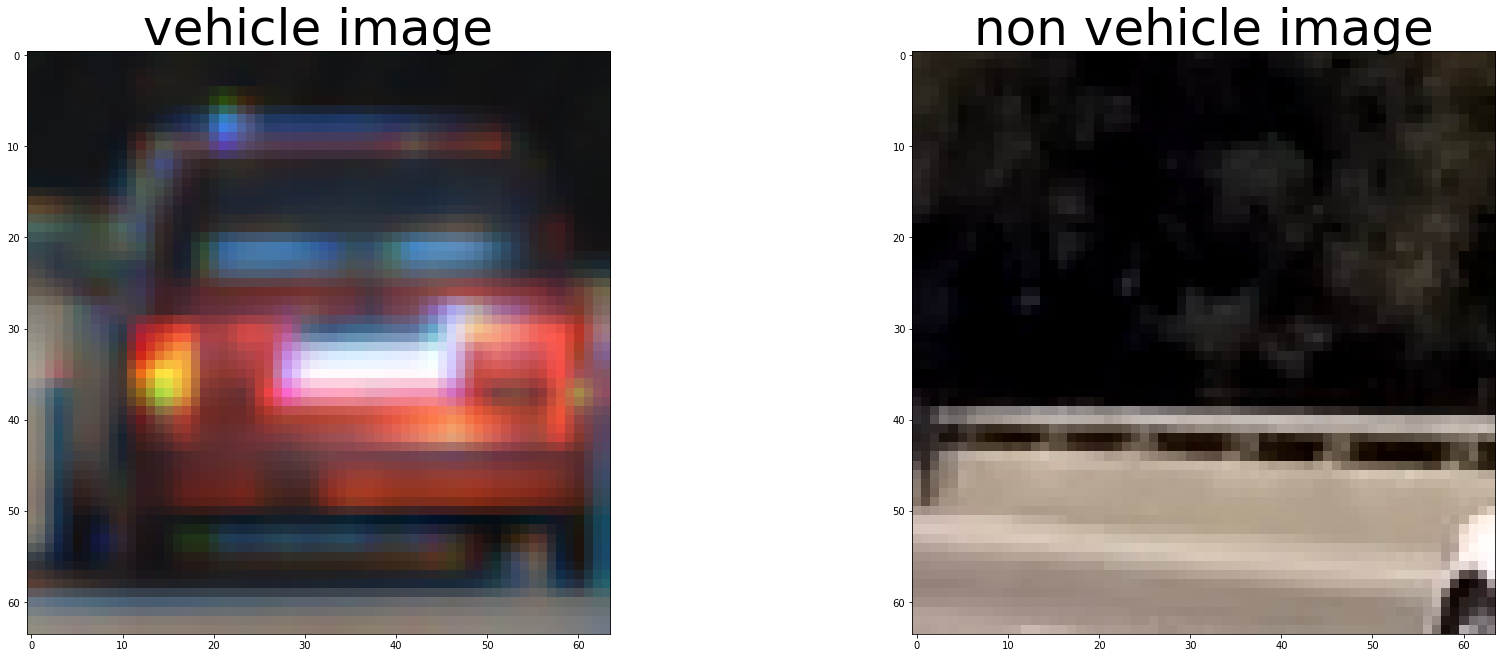

In [3]:
# print(len(cars))
# print(len(notcars))


ind1 = np.random.randint(0, len(cars))
car_image = mpimg.imread(cars[ind1])

ind2 = np.random.randint(0, len(notcars))
not_car_image = mpimg.imread(notcars[ind2])

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(car_image)
ax1.set_title('vehicle image', fontsize=50)
ax2.imshow(not_car_image)
ax2.set_title('non vehicle image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.) 
f.savefig('./output_images/car_not_car.png')

***Histogram of Gradient exploration***

In [4]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True,transform_sqrt = False,block_norm  = 'L1'):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features
    
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    if conv == 'COLOR_RGB2Lab':
        return cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    if conv == 'COLOR_RGB2XYZ':
        return cv2.cvtColor(img, cv2.COLOR_RGB2XYZ)
    if conv == 'YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)


# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features 

def explore_colorspaces_HOG(img,non_img,size = 32,save_color_space='RGB2YCrCb'):
    img_copy = np.copy(img)
    img_copy = cv2.resize(img_copy,(size,size))
    
    non_img_copy = np.copy(non_img)
    non_img_copy = cv2.resize(non_img_copy,(size,size))
    
    colorspace_list = ['RGB2YCrCb','RGB2LUV','RGB2HSV','COLOR_RGB2Lab','COLOR_RGB2XYZ','YUV']
    
    for colorspace in  colorspace_list:
        img = convert_color(img_copy, conv=colorspace)
        non_img = convert_color(non_img_copy, conv=colorspace)
        for i in range(0,3):
            features, hog_image = get_hog_features(img[:,:,i], orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True)
            features_notcar, hog_image_notcar = get_hog_features(non_img[:,:,i], orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True)
            
            size_small = int(size/2)
            
            img_resize = cv2.resize(img[:,:,i],(size_small,size_small))
            
            
            non_img_resize = cv2.resize(non_img[:,:,i],(size_small,size_small))
            
            fontSize = 18
            
            if i == 0:
                f, ax = plt.subplots(1, 4, figsize=(24, 9))
                f.tight_layout()
            
        
                ax[0].set_title('Car color space {} \nchannel: {}'.format(colorspace,1+i), fontsize=fontSize)
                ax[0].imshow(img[:,:,i],cmap = "gray")
        
                ax[1].set_title('Car HOG color space {} \nchannel: {}'.format(colorspace,1+i), fontsize=fontSize)
                ax[1].imshow(hog_image,cmap = "gray")
        
                ax[2].set_title('Not Car \n color space {} \nchannel: {}'.format(colorspace,1+i), fontsize=fontSize)
                ax[2].imshow(non_img[:,:,i],cmap = "gray")
        
                ax[3].set_title('Not Car HOG \ncolor space {} \nchannel: {}'.format(colorspace,1+i), fontsize=fontSize)
                ax[3].imshow(hog_image_notcar,cmap = "gray")
        
                plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
                if colorspace == save_color_space:
                    f.savefig('./output_images/HOG_example_1.jpg')
            
                f, ax = plt.subplots(1, 4, figsize=(24, 9))
                f.tight_layout()
            
        
                ax[0].set_title('Car features color space {} \nchannel: {}'.format(colorspace,1+i), fontsize=fontSize)
                ax[0].imshow(img[:,:,i],cmap = "gray")
        
                ax[1].set_title('Car features  HOG color space {}\nchannel: {}'.format(colorspace,1+i), fontsize=fontSize)
                ax[1].imshow( img_resize,cmap = "gray")
        
                ax[2].set_title('Not Car \nfeatures  color space {}\nchannel: {}'.format(colorspace,1+i), fontsize=fontSize)
                ax[2].imshow(non_img[:,:,i],cmap = "gray")
        
                ax[3].set_title('Not Car features HOG \ncolor space {}\nchannel: {}'.format(colorspace,1+i), fontsize=fontSize)
                ax[3].imshow(non_img_resize,cmap = "gray")
        
                plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
                if colorspace == save_color_space:
                    f.savefig('./output_images/HOG_example_2.jpg'.format(i+2))
            
            if i == 1:
                f, ax = plt.subplots(1, 4, figsize=(24, 9))
                f.tight_layout()
            
        
                ax[0].set_title('Car features color space {} \nchannel: {}'.format(colorspace,1+i), fontsize=fontSize)
                ax[0].imshow(img[:,:,i],cmap = "gray")
        
                ax[1].set_title('Car features  HOG color space {}\nchannel: {}'.format(colorspace,1+i), fontsize=fontSize)
                ax[1].imshow( img_resize,cmap = "gray")
        
                ax[2].set_title('Not Car \nfeatures  color space {}\nchannel: {}'.format(colorspace,1+i), fontsize=fontSize)
                ax[2].imshow(non_img[:,:,i],cmap = "gray")
        
                ax[3].set_title('Not Car features HOG \ncolor space {}\nchannel: {}'.format(colorspace,1+i), fontsize=fontSize)
                ax[3].imshow(non_img_resize,cmap = "gray")
        
                plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
                if colorspace == save_color_space:
                    f.savefig('./output_images/HOG_example_3.jpg')
            
            if i == 2:
                f, ax = plt.subplots(1, 4, figsize=(24, 9))
                f.tight_layout()
            
        
                ax[0].set_title('Car features color space {}\nchannel: {}'.format(colorspace,1+i), fontsize=fontSize)
                ax[0].imshow(img[:,:,i],cmap = "gray")
        
                ax[1].set_title('Car features  HOG color space {}\nchannel: {}'.format(colorspace,1+i), fontsize=fontSize)
                ax[1].imshow(img_resize,cmap = "gray")
        
                ax[2].set_title('Not Car features  \ncolor space {}\nchannel: {}'.format(colorspace,1+i), fontsize=fontSize)
                ax[2].imshow(non_img[:,:,i],cmap = "gray")
        
                ax[3].set_title('Not Car features HOG \ncolor space {}\nchannel: {}'.format(colorspace,1+i), fontsize=fontSize)
                ax[3].imshow(non_img_resize,cmap = "gray")
        
                plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
                if colorspace == save_color_space:
                    f.savefig('./output_images/HOG_example_4.jpg')
           
        
        
#         print(features_reshape.shape)
#         print(hog_image.shape)

        
    

/Users/test/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)
/Users/test/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:144: RuntimeWarning: invalid value encountered in sqrt
  image = np.sqrt(image)
/Users/test/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


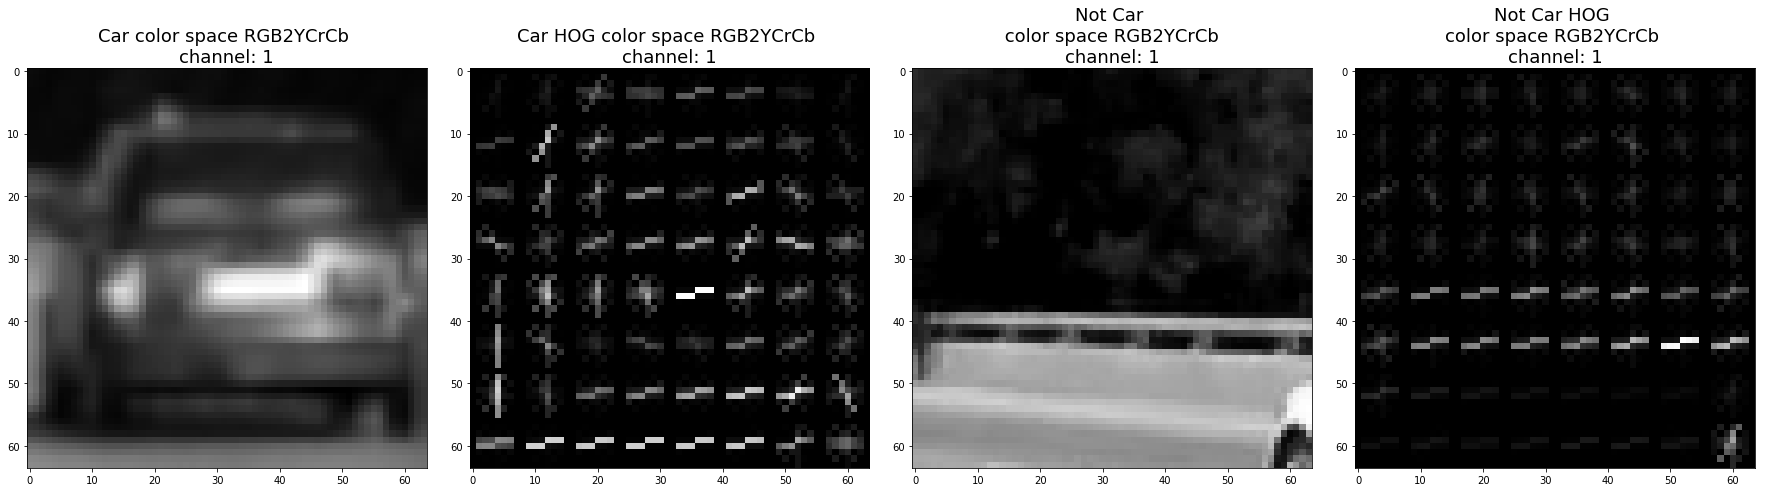

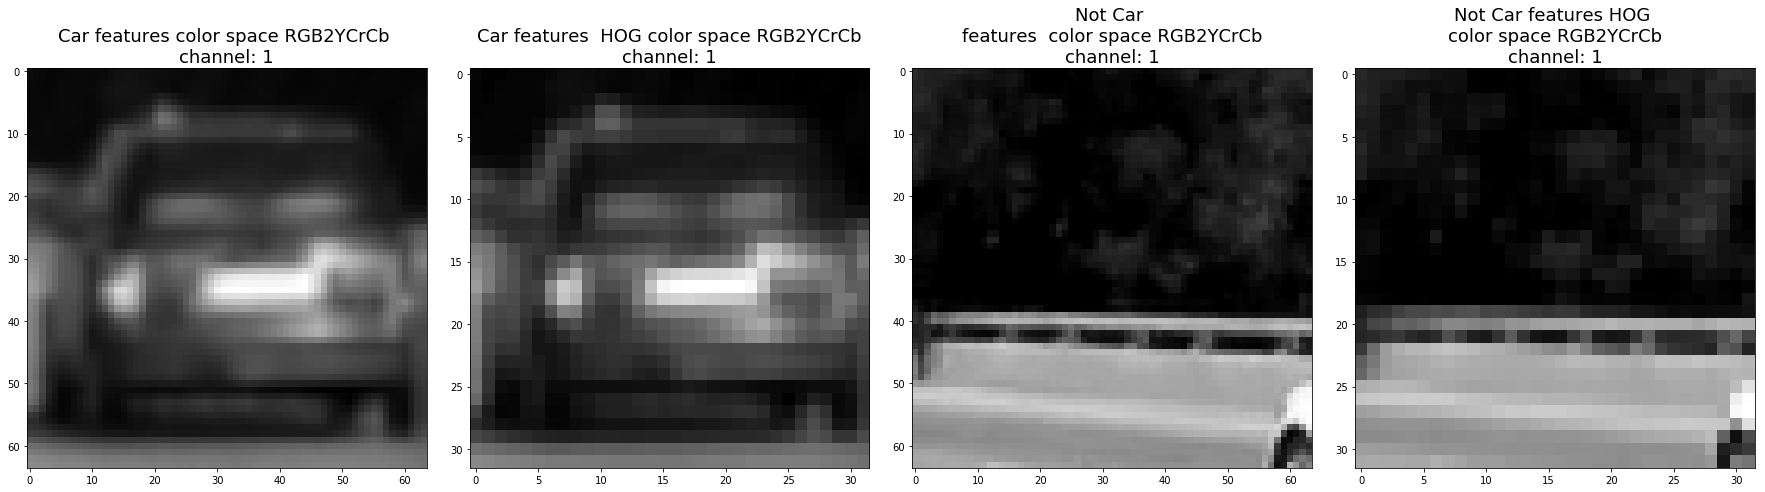

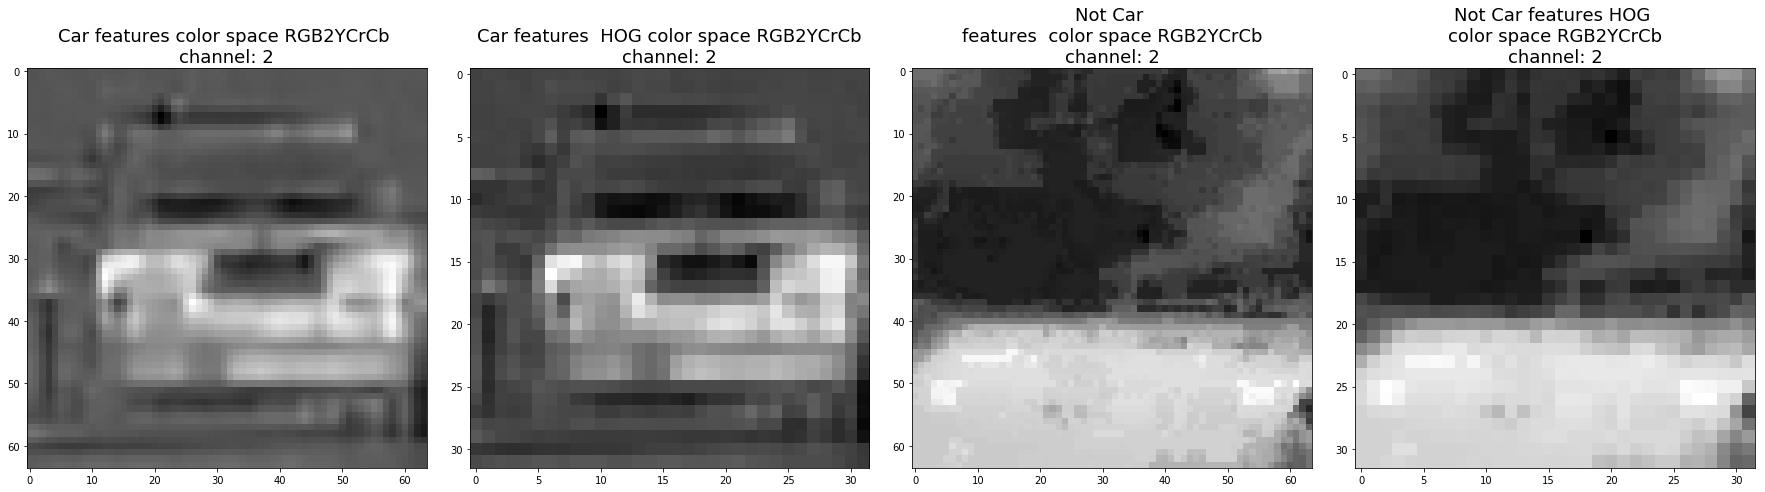

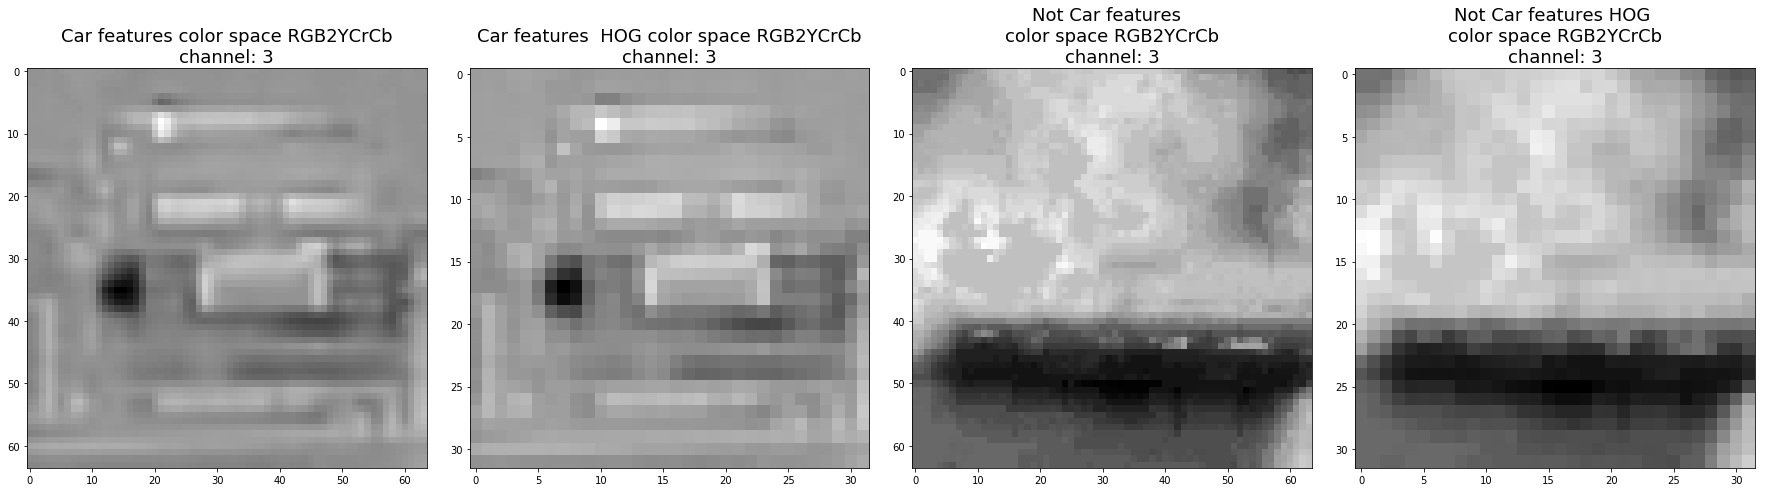

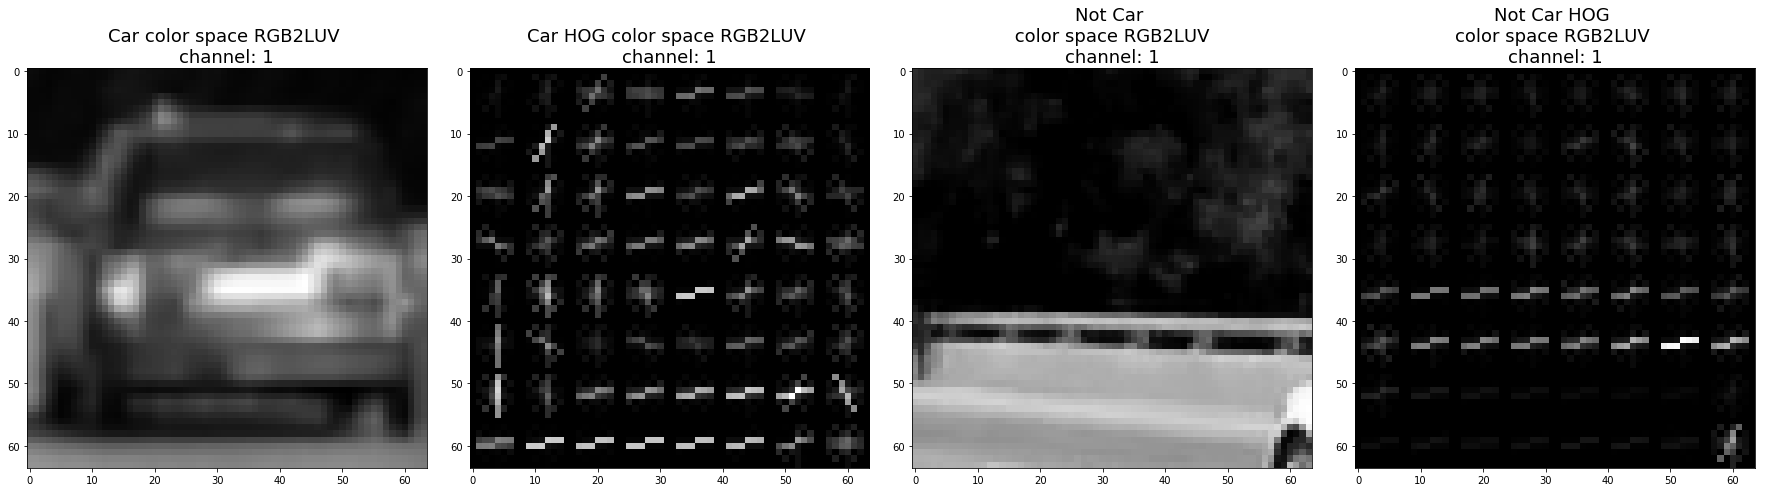

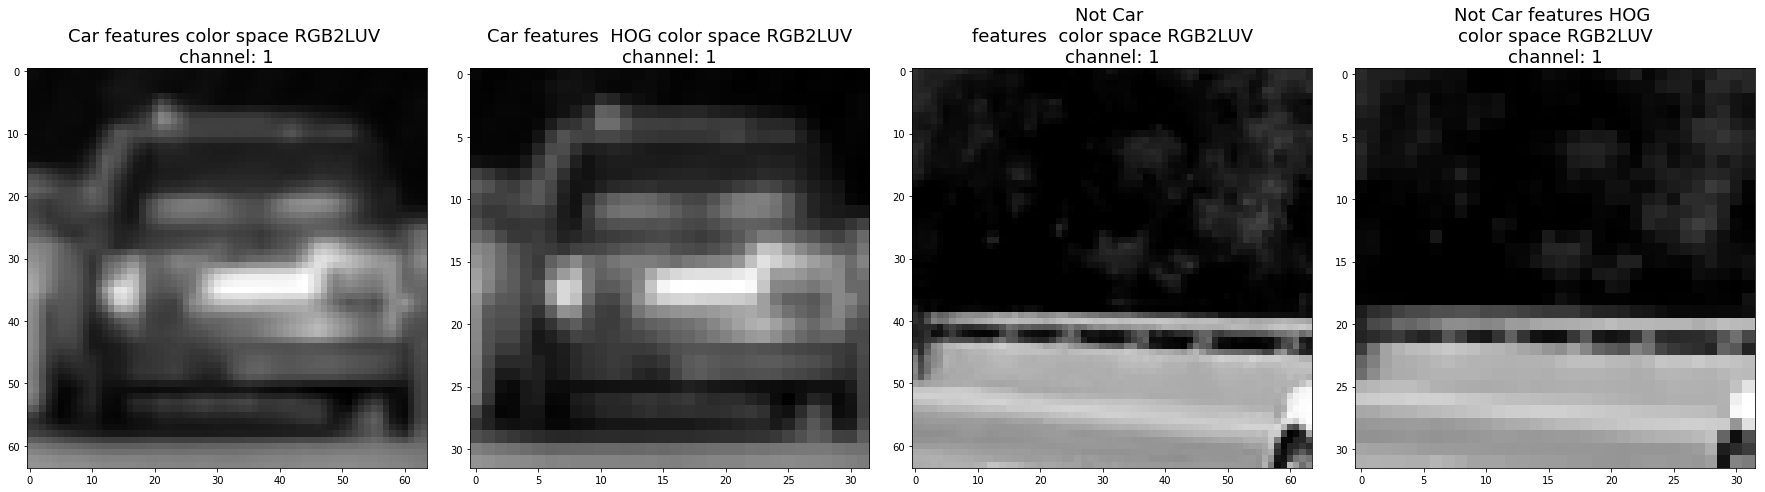

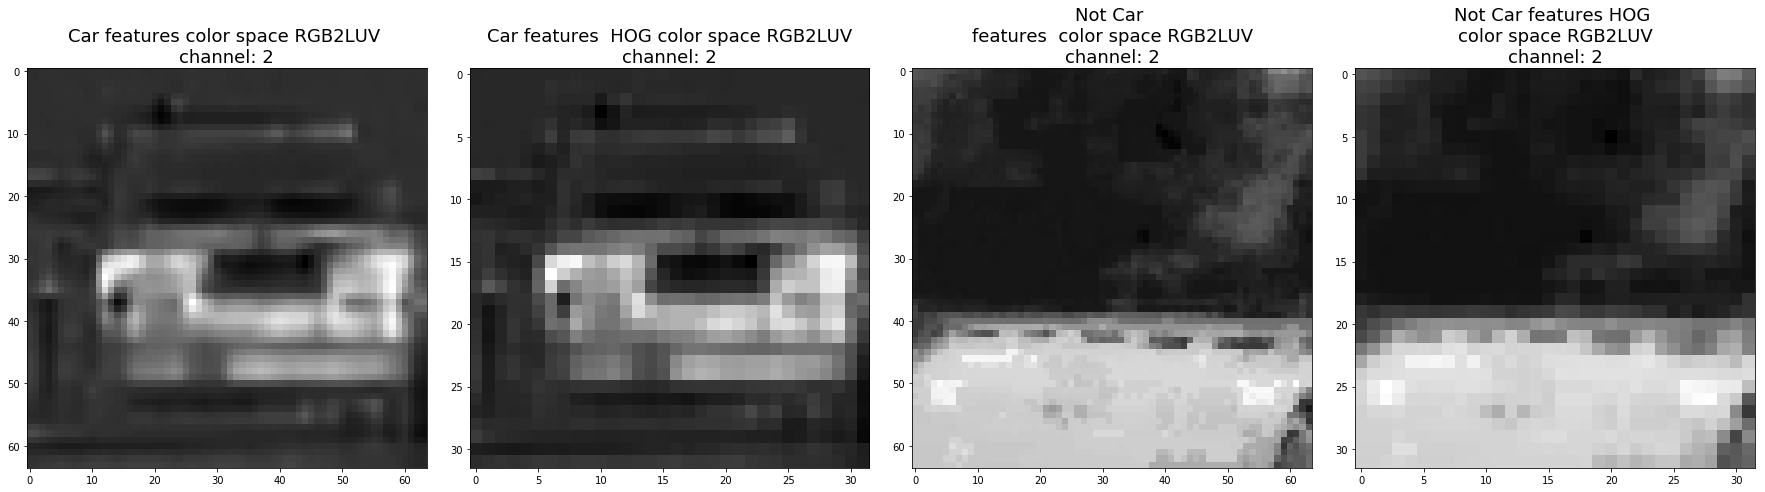

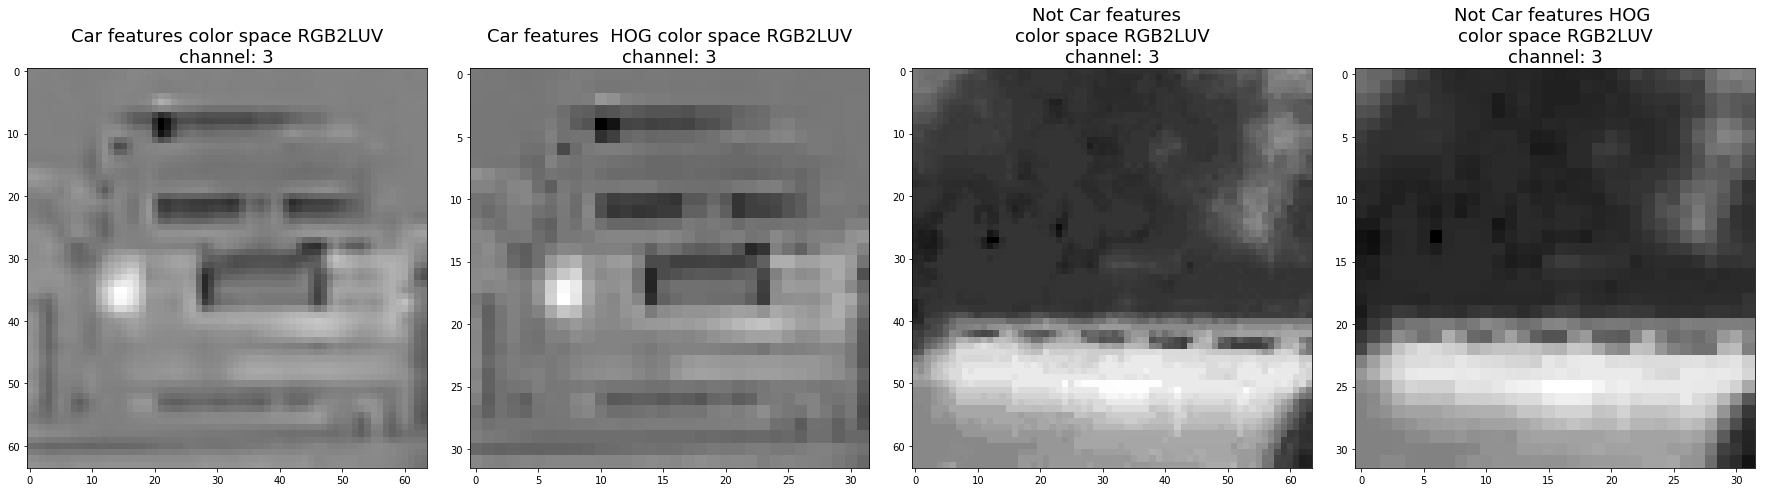

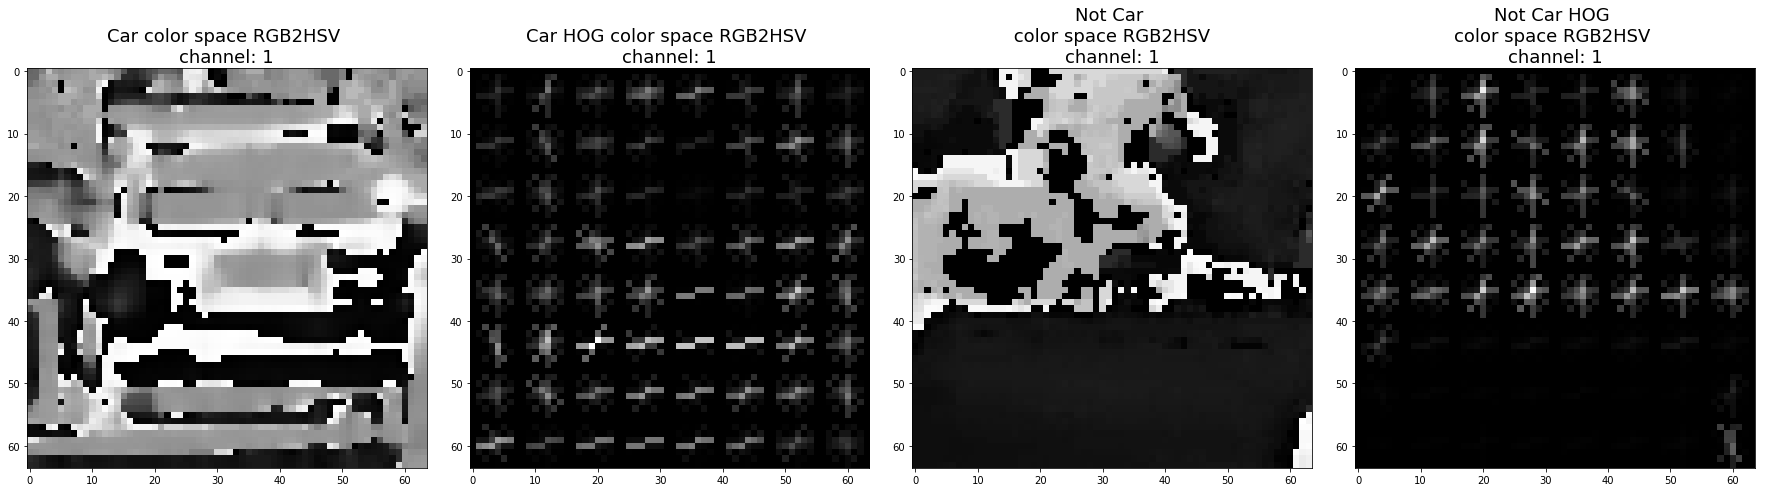

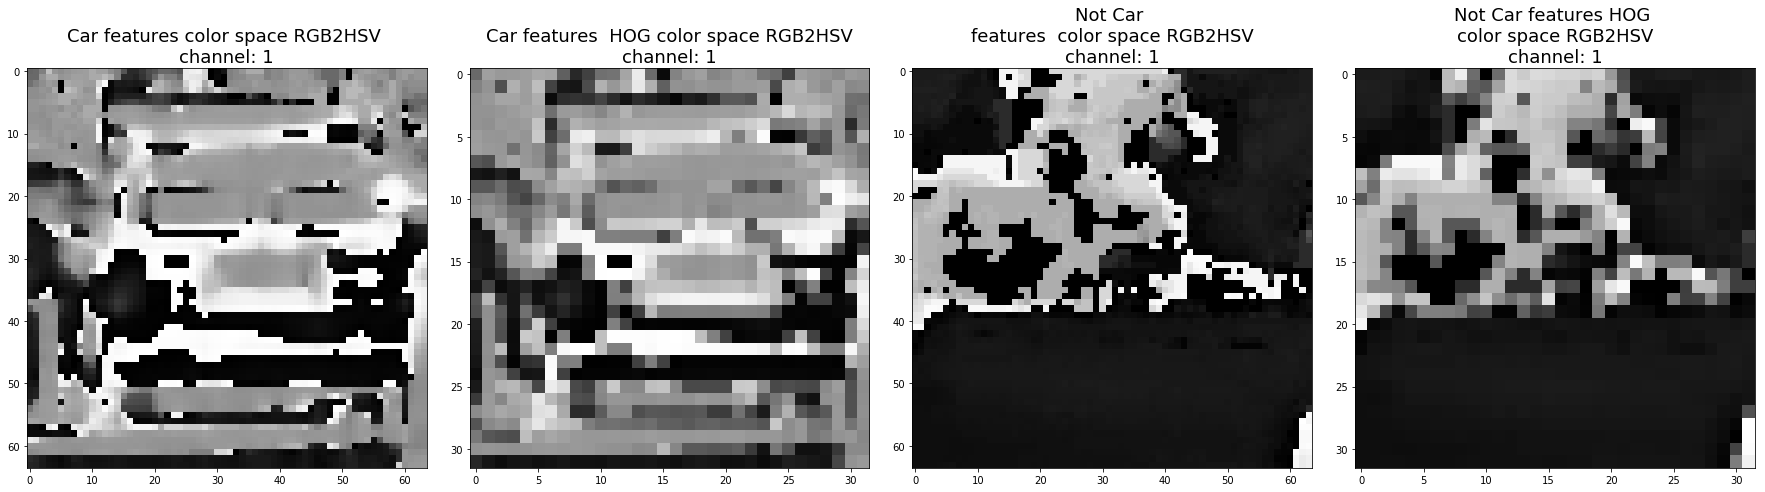

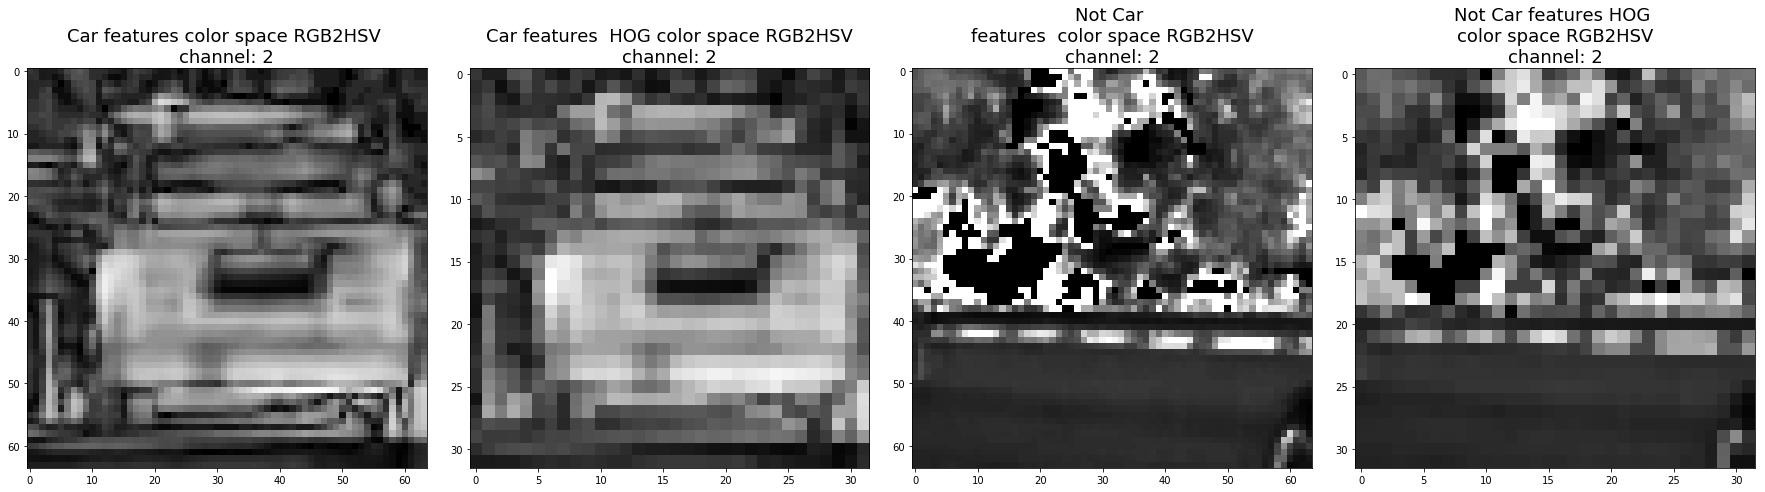

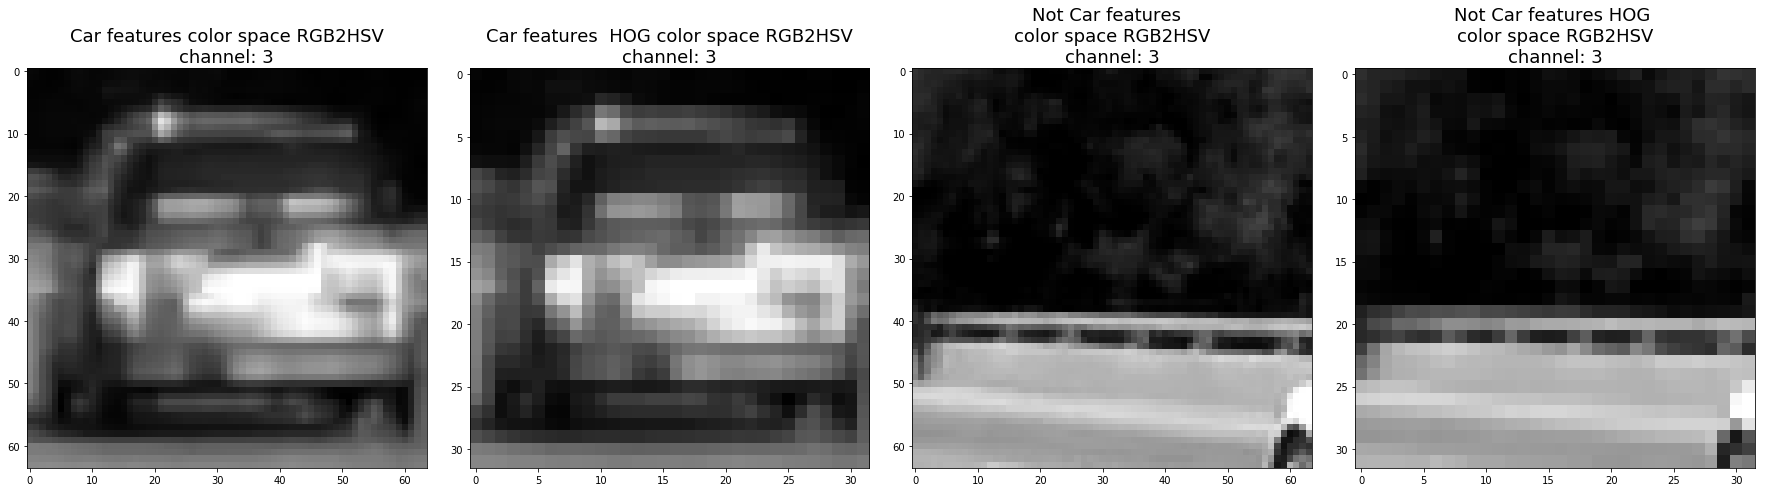

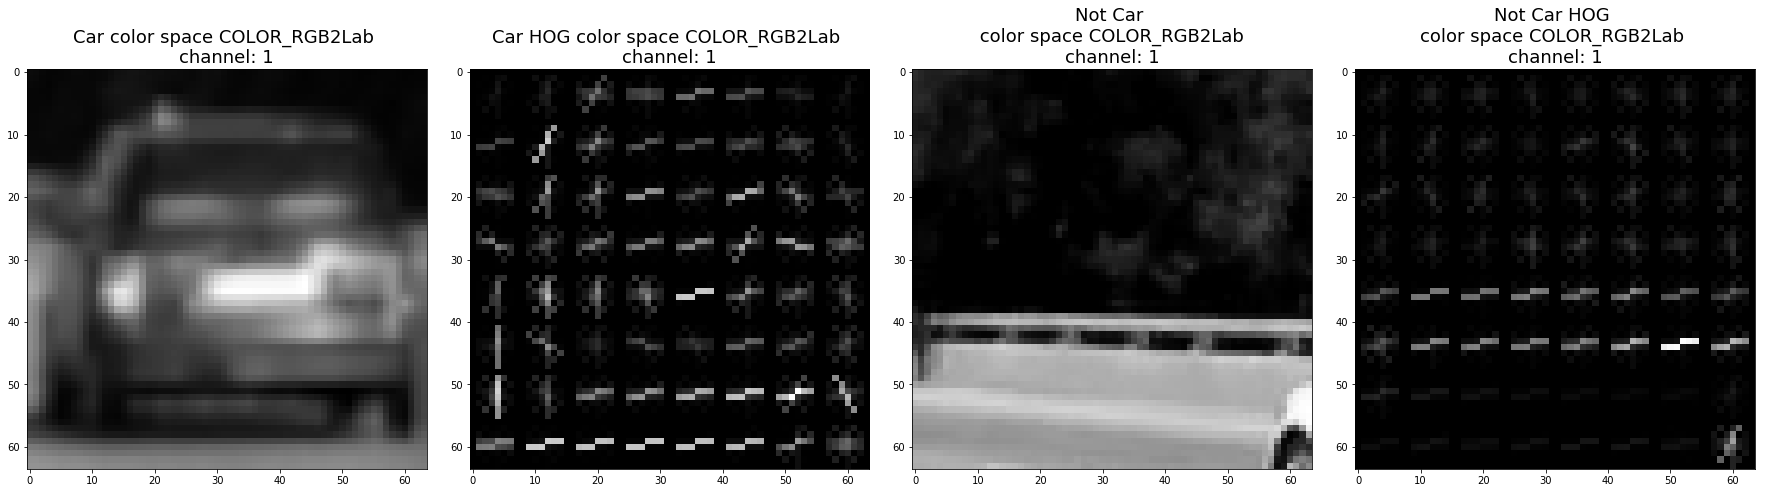

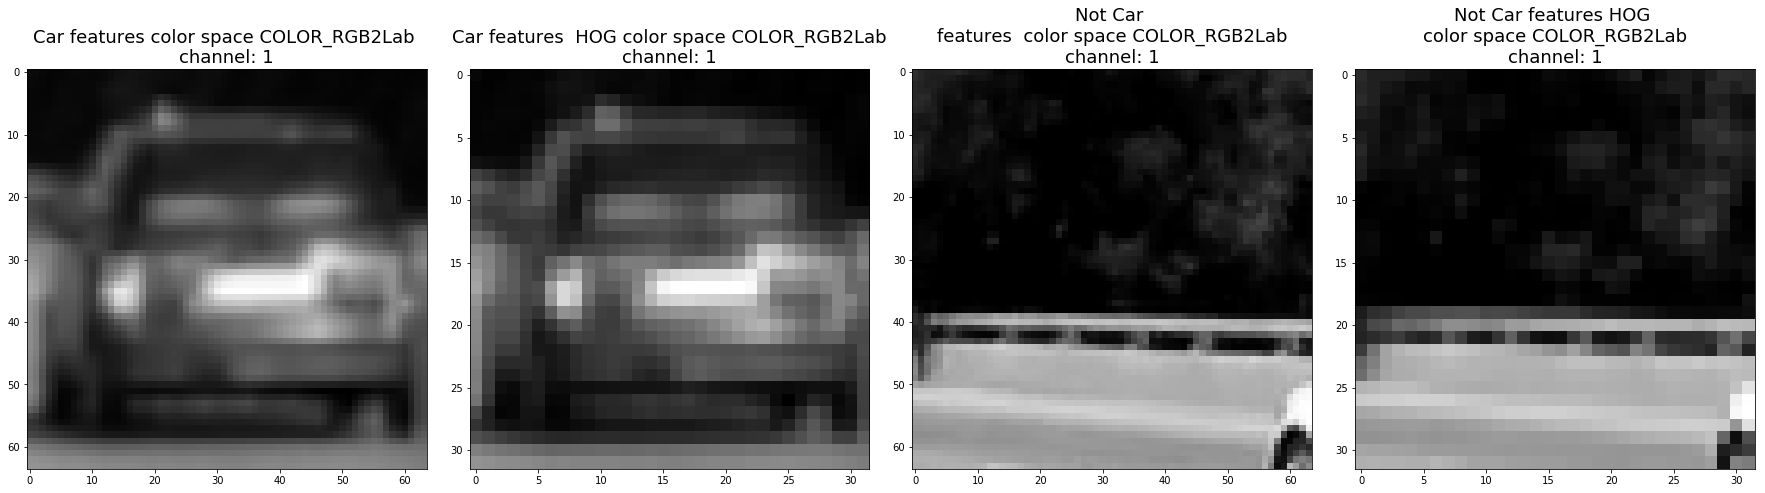

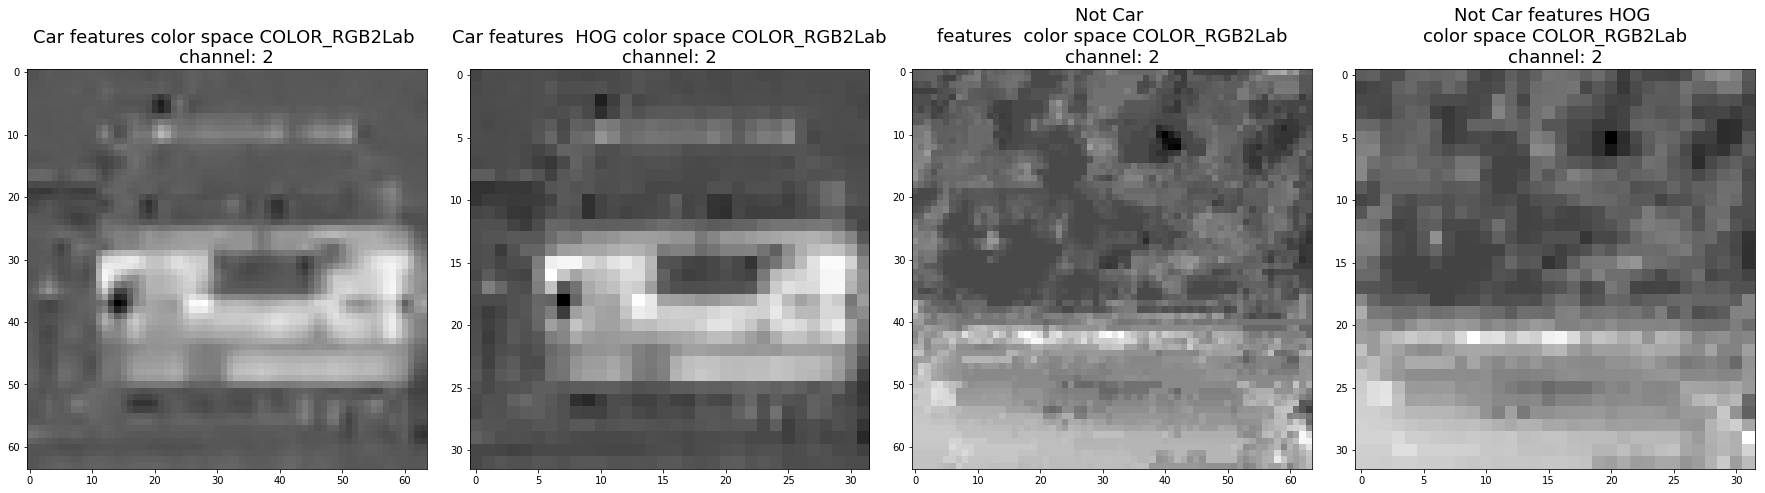

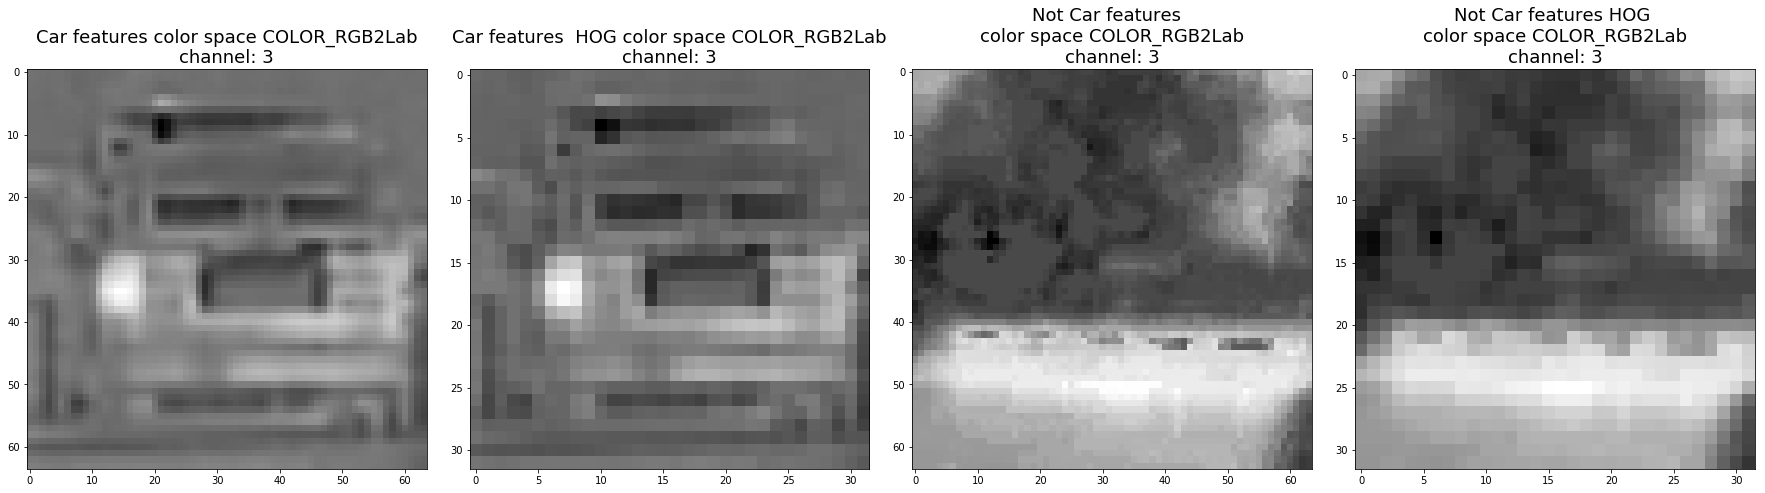

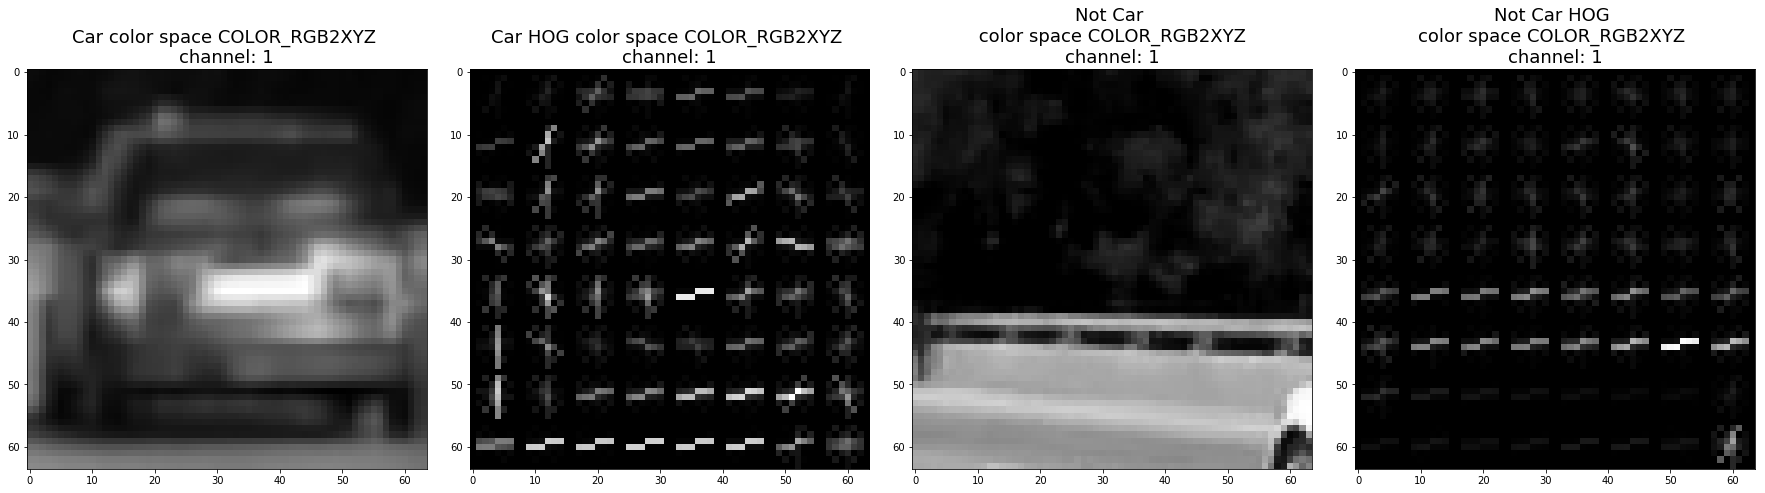

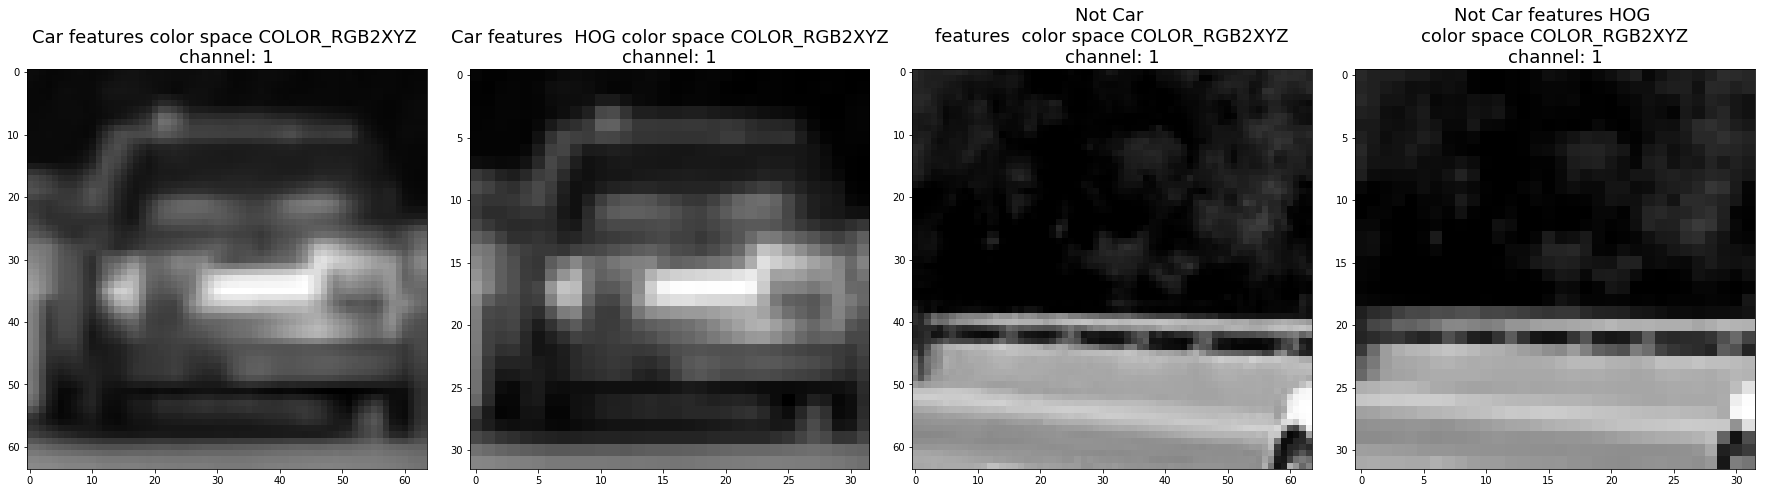

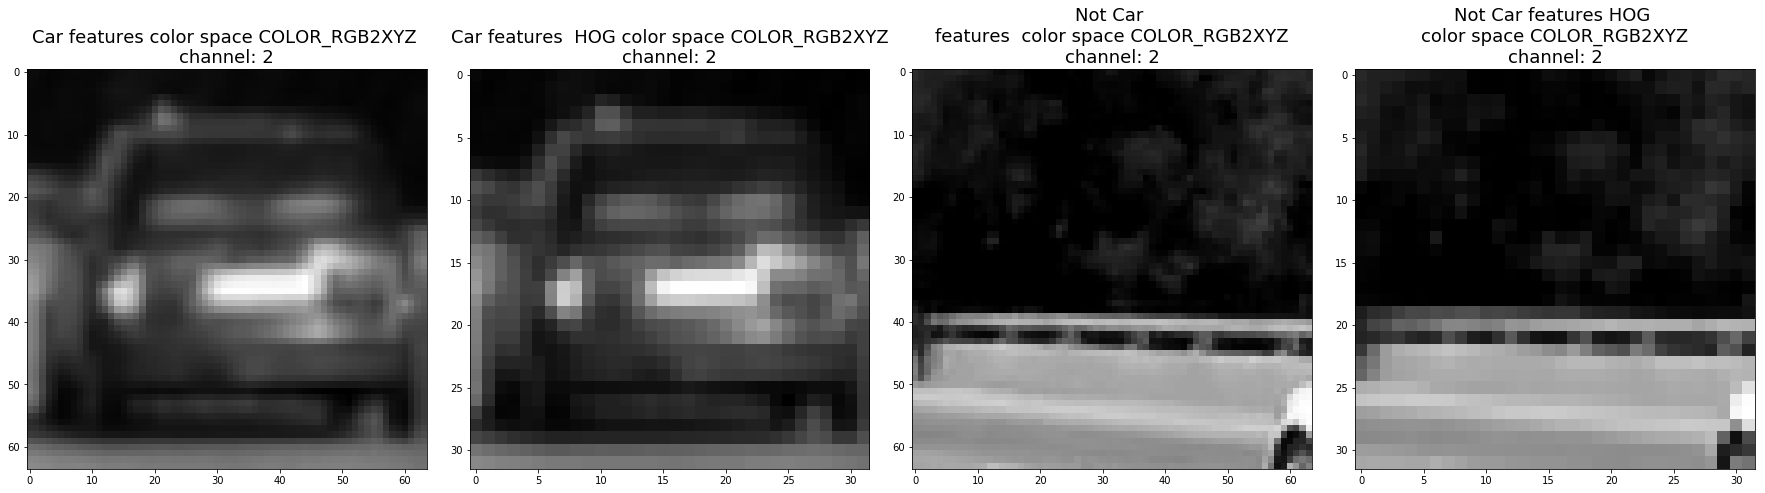

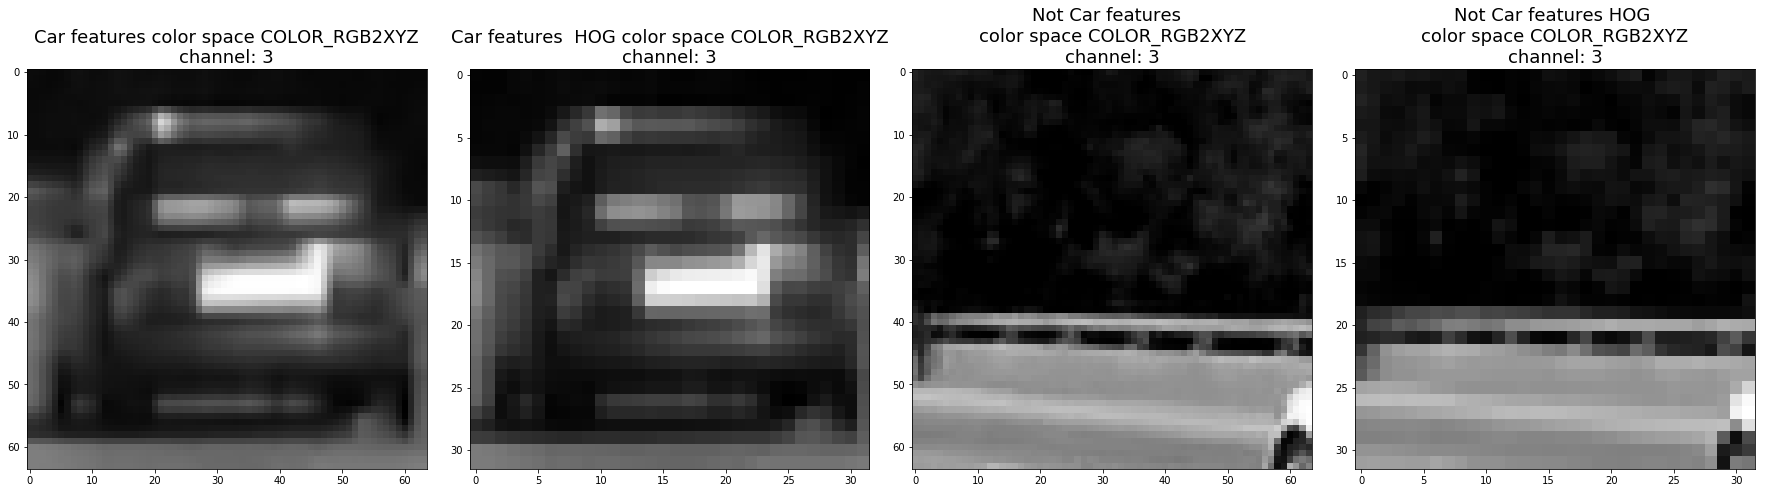

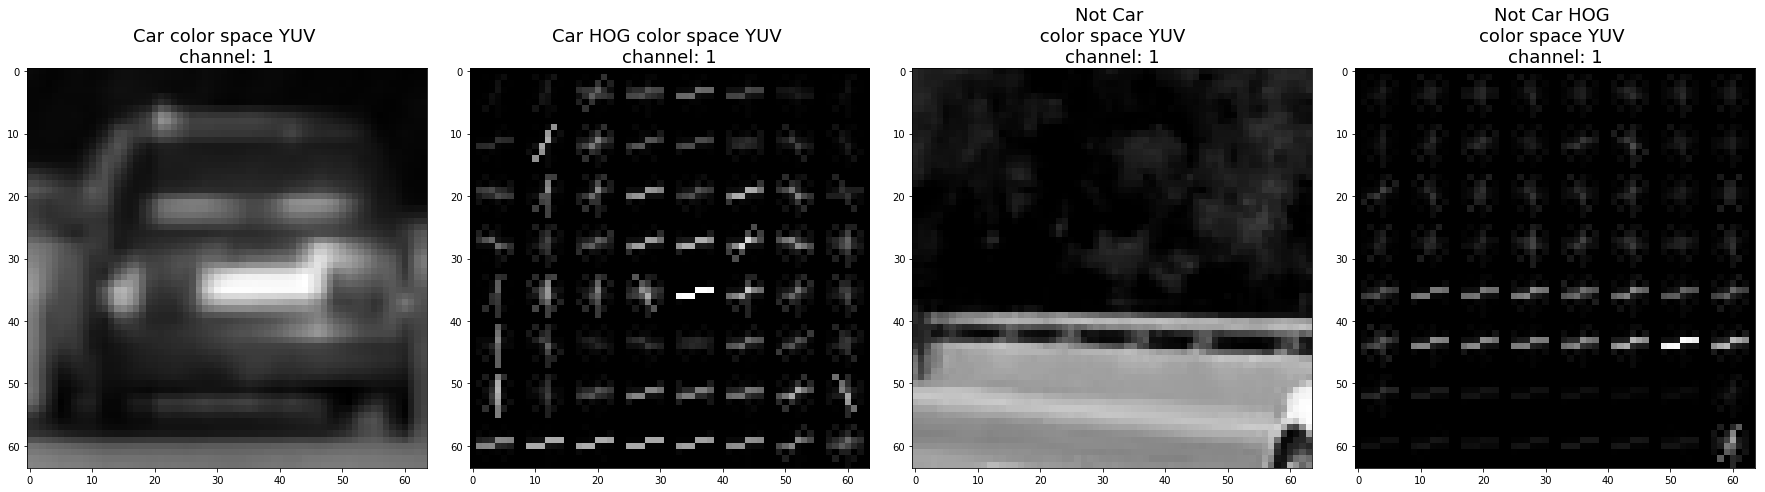

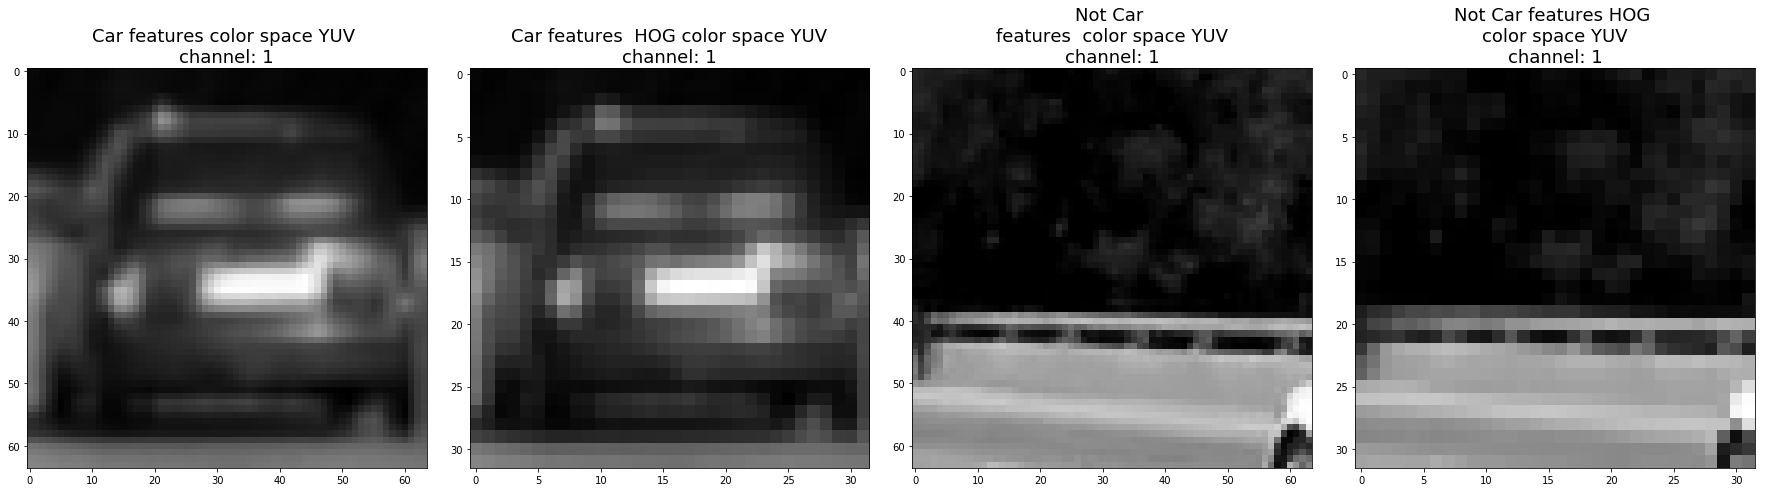

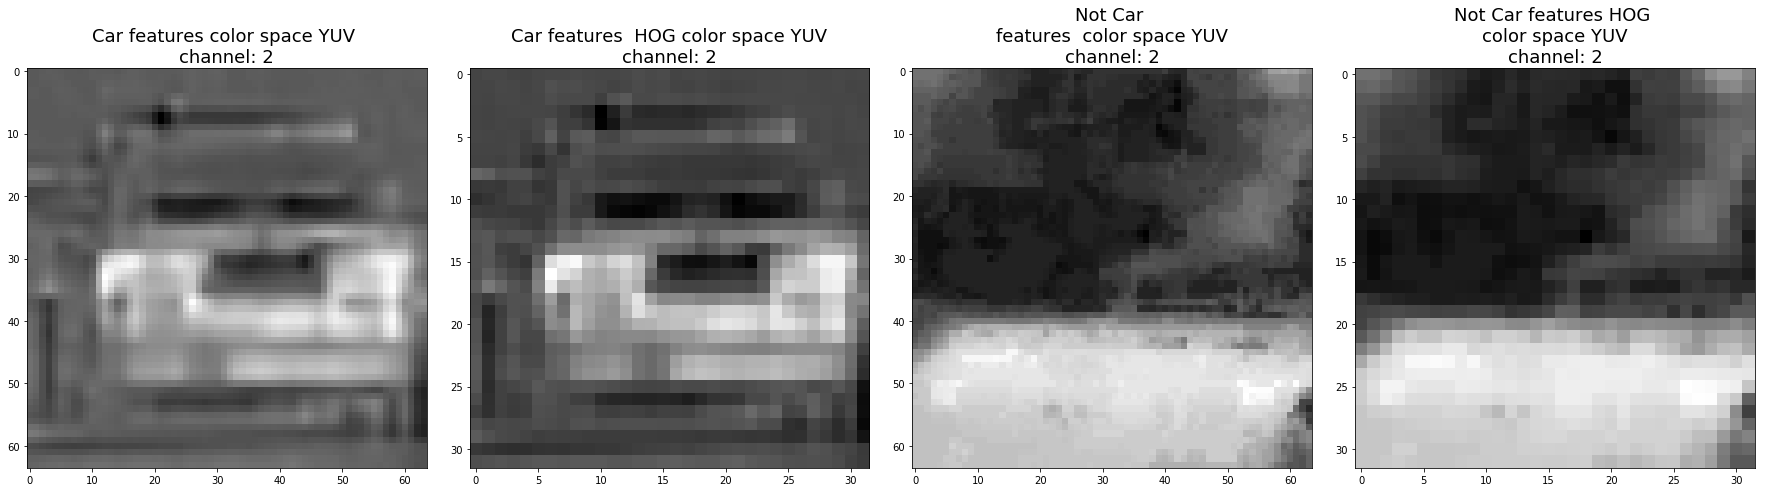

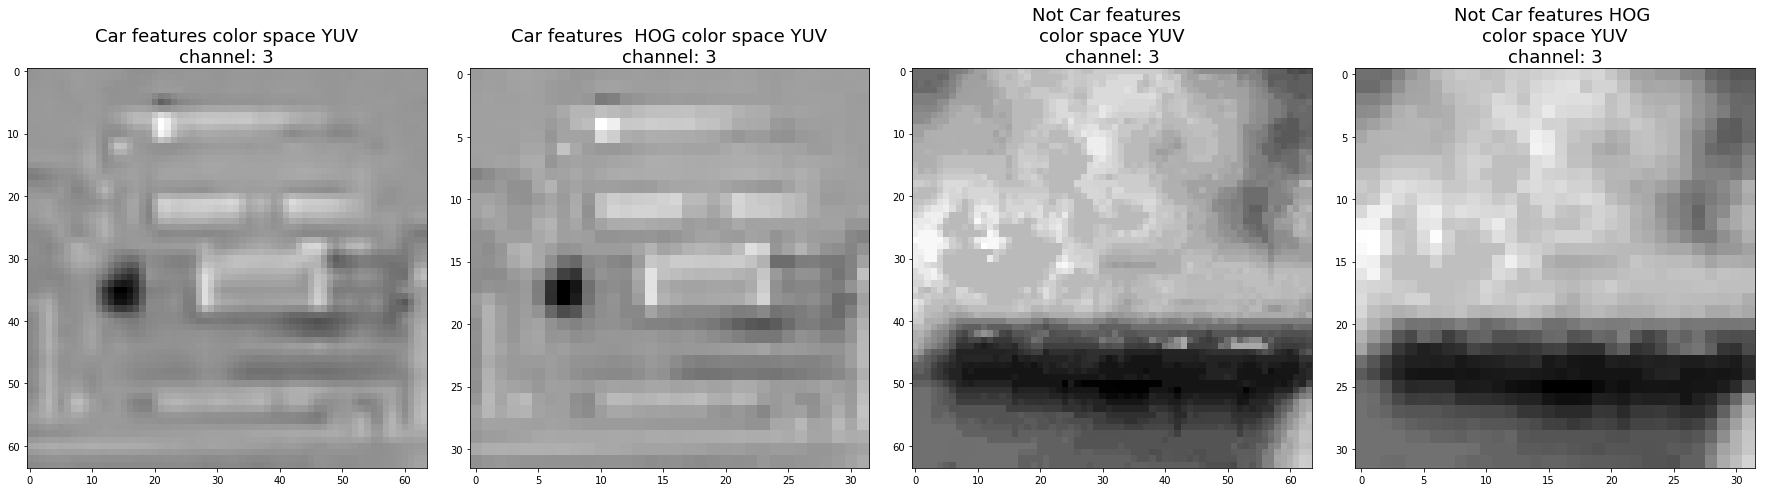

In [5]:
# Define HOG parameters
pix_per_cell = 8
cell_per_block = 2
orient = 9
size = 64


explore_colorspaces_HOG(car_image,not_car_image,size = size,save_color_space ='RGB2YCrCb' )



***Color space exploration***

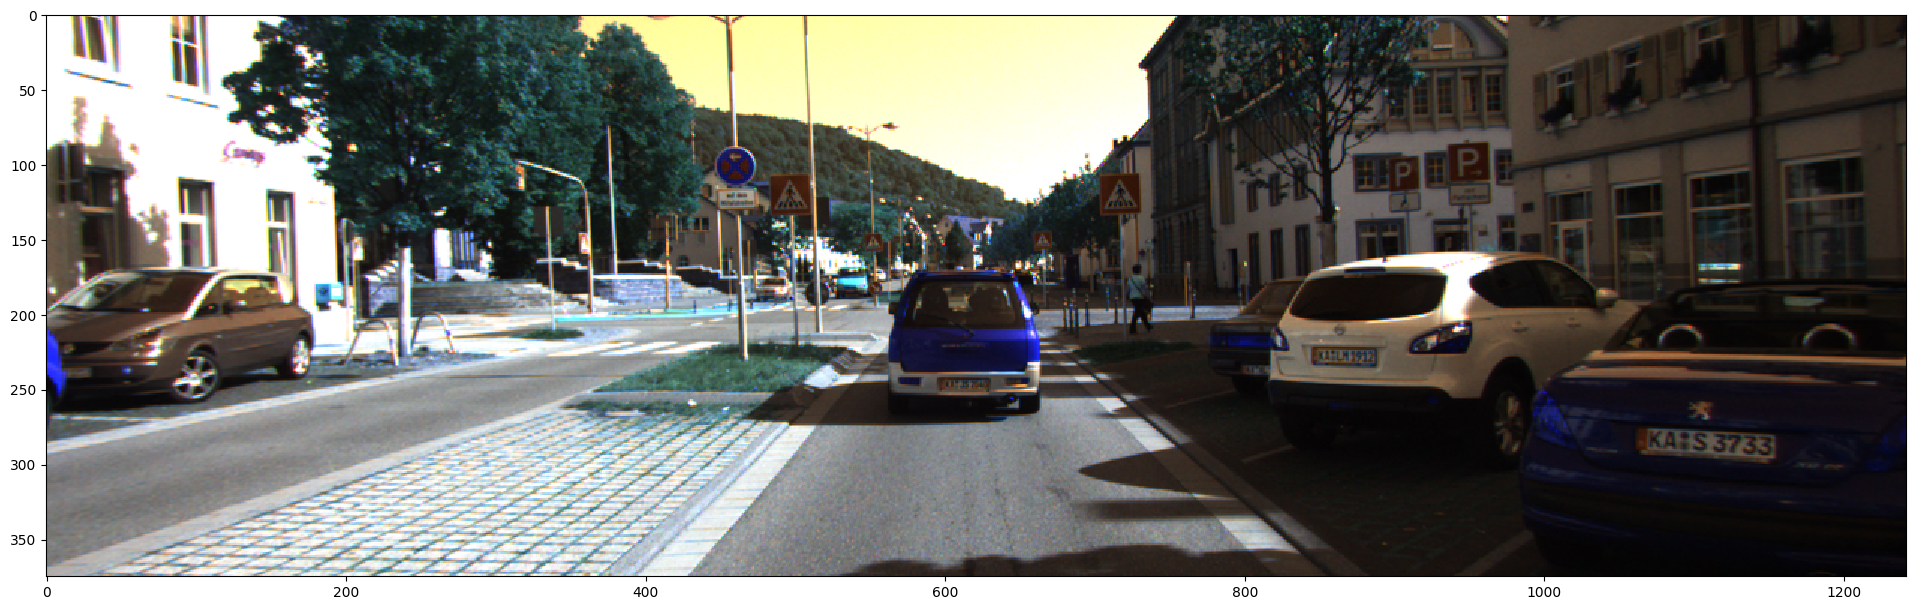

In [6]:
# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!

def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def plot3d(pixels, colors_rgb,
        axis_labels=list("RGB"), axis_limits=[(0, 255), (0, 255), (0, 255)]):
    """Plot pixels in 3D."""

    # Create figure and 3D axes
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')

    return ax  # return Axes3D object for further manipulation

img = cv2.imread("./colorspace_exploration/000275.png")

# Select a small fraction of pixels to plot by subsampling it
scale = max(img.shape[0], img.shape[1], 64) / 64  # at most 64 rows and columns
img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)


# Convert subsampled image to desired color space(s)
img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR, matplotlib likes RGB
img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV)
img_small_LUV = cv2.cvtColor(img_small, cv2.COLOR_BGR2LUV)
img_small_YCrCb = cv2.cvtColor(img_small, cv2.COLOR_BGR2YCrCb)
img_small_Lab = cv2.cvtColor(img_small, cv2.COLOR_BGR2Lab)
img_small_YUV = cv2.cvtColor(img_small, cv2.COLOR_BGR2YUV)
img_small_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for plotting

%matplotlib inline
fig = plt.figure(figsize=(24, 14), dpi=100)
plt.imshow(img)


<IPython.core.display.Javascript object>


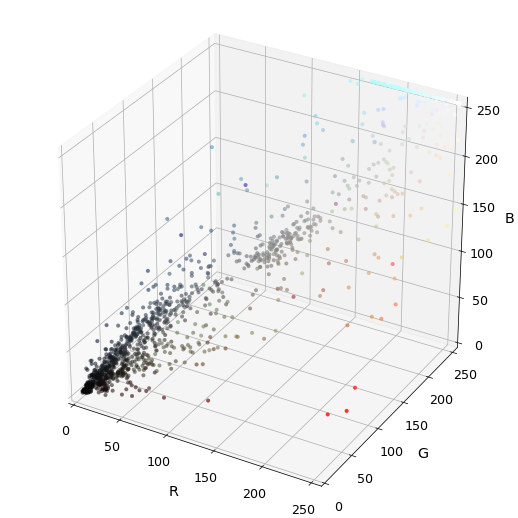

In [11]:
%matplotlib notebook 
plot3d(img_small_RGB, img_small_rgb)
plt.show()

<IPython.core.display.Javascript object>


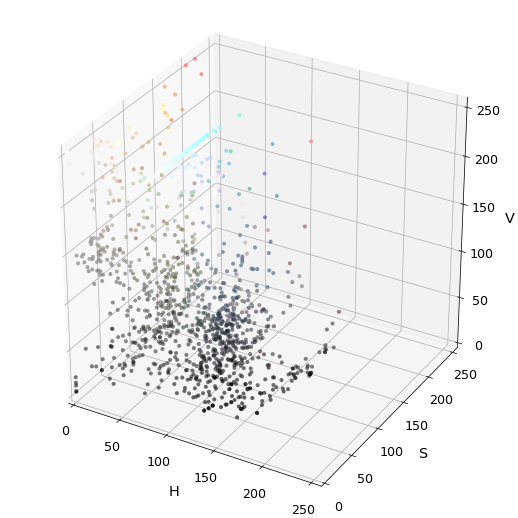

In [12]:
%matplotlib notebook
plot3d(img_small_HSV, img_small_rgb, axis_labels=list("HSV"))
plt.show()

<IPython.core.display.Javascript object>


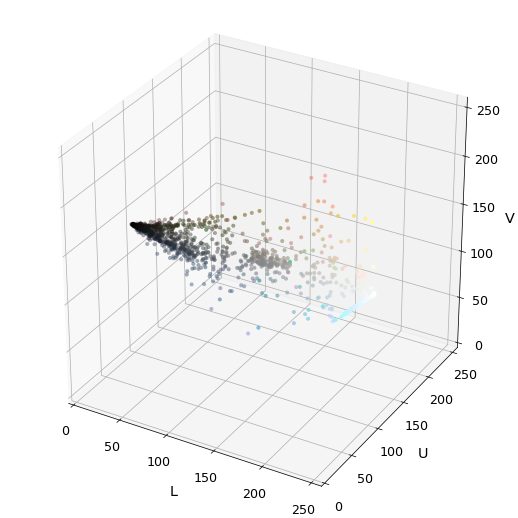

In [13]:
%matplotlib notebook
plot3d(img_small_LUV, img_small_rgb, axis_labels=list("LUV"))
plt.show()

<IPython.core.display.Javascript object>


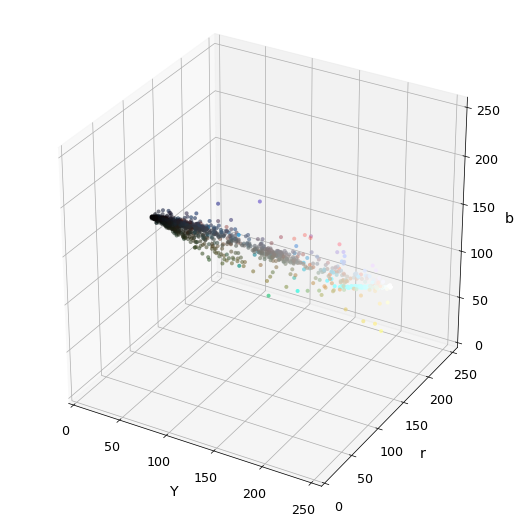

In [14]:
%matplotlib notebook
plot3d(img_small_YCrCb, img_small_rgb, axis_labels=list("Yrb"))
plt.show()

<IPython.core.display.Javascript object>


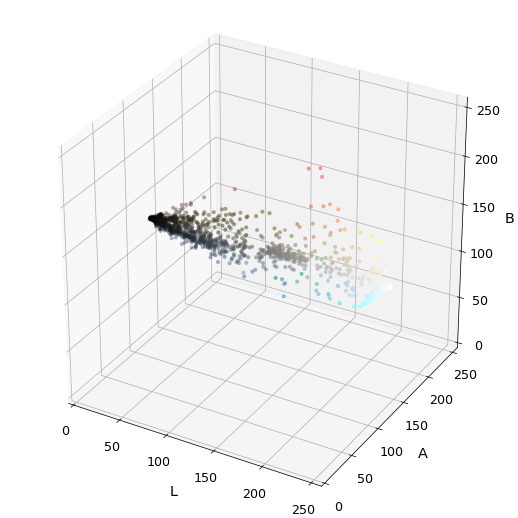

In [15]:
%matplotlib notebook
plot3d(img_small_Lab, img_small_rgb, axis_labels=list("LAB"))
plt.show()

<IPython.core.display.Javascript object>


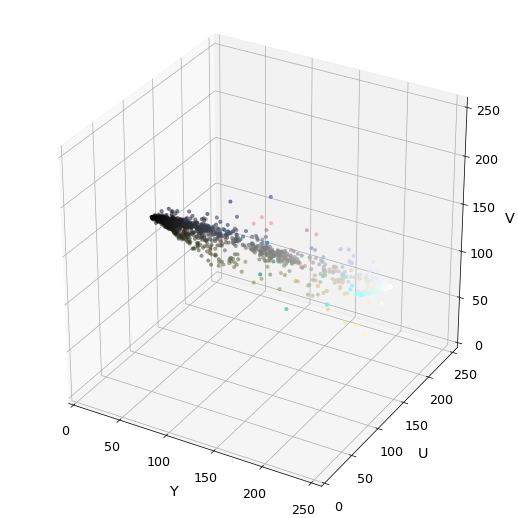

In [16]:
%matplotlib notebook
plot3d(img_small_YUV, img_small_rgb, axis_labels=list("YUV"))
plt.show()

### Extract Features

In [17]:


%matplotlib inline

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = cv2.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
#         if(len(features)%1000 == 0):
#             print("loaded {} features".format(len(features)))
    # Return list of feature vectors
    return features
    


In [ ]:
size = 32
### TODO: Tweak these parameters and see how the results change.
color_space = 'HSV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (size, size) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, 700] # Min and max in y to search in slide_window()

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)



/Users/test/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


### Train SVM classifier

In [ ]:
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = SVC(C=10.0, kernel='linear')
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460


### define sliding window

In [ ]:
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
#     img = img.astype(np.float32)/255
    bbox =[]
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2HSV')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
  
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
 
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
          

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            
            hist_features = color_hist(subimg, nbins=hist_bins)
           

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features,  hog_features)).reshape(1, -1)) 
            
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)
                bbox.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return draw_img,bbox
    


In [ ]:

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        if np.abs(bbox[0][0]-bbox[1][0]) > 50 and np.abs(bbox[0][1]-bbox[1][1]) > 50:
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


### Test sliding window on  test images

In [ ]:

# test images in test_images folder
%matplotlib inline
def show_test_images_and_heatmaps():
    for file in os.listdir(path='./test_images'):
        if file != '.DS_Store':
            image = cv2.imread('./test_images/'+file)
        
            draw_image = np.copy(image)
            ystart = int(image.shape[0]/2.0)
            ystop = int(image.shape[0] - 32)
            scale = 1.5
            out_img,bbox = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)                       
            heat = np.zeros_like(image[:,:,0]).astype(np.float)
            # Add heat to each box in box list
            heat = add_heat(heat,bbox)
        
            # Apply threshold to help remove false positives
            heat = apply_threshold(heat,0)

            # Visualize the heatmap when displaying    
            heatmap = np.clip(heat, 0, 255)
            
            # Find final boxes from heatmap using label function
            labels = label(heatmap)
            draw_img = draw_labeled_bboxes(np.copy(image), labels)
            
            
            
            f, ax = plt.subplots(1, 3, figsize=(24, 9))
            f.tight_layout()
            fontSize = 18
            
            ax[0].set_title('\n{} Original\n'.format(file), fontsize=fontSize)
            ax[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            
            ax[1].set_title('\n{} detected vehicles\n'.format(file), fontsize=fontSize)
            ax[1].imshow(cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB))

            ax[2].set_title('\n{} heat map\n'.format(file), fontsize=fontSize)
            ax[2].imshow(heatmap,cmap='hot')
        
            plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
            f.savefig('./output_images/'+file)

            
        

In [ ]:
show_test_images_and_heatmaps()

### create pipeline

In [ ]:

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
average_list = []
avg_heat = None
previous_heat = None;

def heatmap_average(heat,average_number = 3,threshold = 3):
    global average_list
    global avg_heat
    if len(average_list) == average_number:
        avg_heat = average_list[0];
        for i in range(1,average_number):
            avg_heat = np.add(avg_heat,average_list[i])
        average_list = []
        avg_heat = apply_threshold(avg_heat,threshold)
        return avg_heat
           
    elif  len(average_list) < average_number:
        average_list.append(heat)
        return avg_heat     
    return    


def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    draw_image = np.copy(image)
    draw_image2 = np.copy(image)
    
    ystart = int(image.shape[0]/2.0)
    ystop = int(image.shape[0] - 32)
    scale = 1.5
    out_img,bbox = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)                       
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
        # Add heat to each box in box list
    heat = add_heat(heat,bbox)
        
    # Apply threshold to help remove false positives
    #heat = apply_threshold(heat,0)
    heat = heatmap_average(heat,average_number = 5,threshold = 10)
    if heat != None:
        global previous_heat 
        # Visualize the heatmap when displaying    
        heatmap = np.clip(heat, 0, 255)
        
        if previous_heat != None:
            heatmap[(heatmap > 1) & (previous_heat > 1)] = 255
            
    
        # Find final boxes from heatmap using label function
        labels = label(heatmap)
        draw_img = draw_labeled_bboxes(np.copy(image), labels)
        font = cv2.FONT_HERSHEY_SIMPLEX
        small_output = cv2.resize( heatmap,(160,90))
        y_position = 60
        x_position = 1050
        small_width = int(draw_image.shape[1] * 0.125)
        small_height = int(draw_image.shape[0]* 0.125)
        small_output_copy = np.zeros_like(small_output)
        small_output_copy_1 = np.zeros_like(small_output)
        small_output_copy[small_output > 0] = 255
        draw_img[y_position:small_height+y_position,x_position:x_position+small_width,0] = small_output_copy
        draw_img[y_position:small_height+y_position,x_position:x_position+small_width,1] = small_output_copy_1
        draw_img[y_position:small_height+y_position,x_position:x_position+small_width,2] = small_output_copy_1
        cv2.putText(draw_img,"Heatmap view",(x_position,40), font, 0.5,(255,255,255),2,cv2.LINE_AA)
        previous_heat = heatmap;
        return draw_img
    
    return draw_image

### Test pipeline on video

In [ ]:
average_list = []
avg_heat = None
previous_heat = None

car_detection_test = 'car_detection1.mp4'
clip1 = VideoFileClip("test_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(car_detection_test, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(car_detection_test))

In [ ]:
average_list = []
avg_heat = None
previous_heat = None

car_detection = 'car_detection2.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(car_detection, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(car_detection))

In [ ]:
average_list = []
avg_heat = None
previous_heat = None
clip = VideoFileClip("car_detection2.mp4")
clip2=clip.resize(width=clip.w//2,height=clip.h//2).speedx(4)
clip2.write_gif("car_detection2.gif",program= 'ffmpeg')

In [ ]:
#create place holder image for video
video_capture = cv2.VideoCapture("car_detection2.mp4")

count = 0;
while count < 500:
    # get frame by frame
    ret, frame = video_capture.read()
    cv2.imwrite('placeholder.png',frame)
    count += 1
